In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Parameters
chr_1_len = 248956422 
G = 14
p_values = [0.75, 0.85]
N_e = 728

In [15]:
# Paths
ceu_map_path = "data/pyrho_CEU_recomb_map_hapmap_format_hg38_chr_1.txt"
yri_map_path = "data/pyrho_YRI_recomb_map_hapmap_format_hg38_chr_1.txt"

In [16]:
# Load maps
ceu_df = pd.read_csv(ceu_map_path, sep="\t", comment="#")
yri_df = pd.read_csv(yri_map_path, sep="\t", comment="#")

ceu_df.columns = ["chrom", "position", "rate_cM_Mb", "genetic_map"]
yri_df.columns = ["chrom", "position", "rate_cM_Mb", "genetic_map"]

ceu_df["position"] = ceu_df["position"].astype(int)
yri_df["position"] = yri_df["position"].astype(int)

In [17]:
# Add position 0 explicitly
ceu_0 = pd.DataFrame([{
    "chrom": ceu_df.iloc[0]["chrom"], "position": 0,
    "rate_cM_Mb": 0.0, "genetic_map": 0.0
}])
yri_0 = pd.DataFrame([{
    "chrom": yri_df.iloc[0]["chrom"], "position": 0,
    "rate_cM_Mb": 0.0, "genetic_map": 0.0
}])

ceu_df = pd.concat([ceu_df, ceu_0], ignore_index=True).sort_values("position")
yri_df = pd.concat([yri_df, yri_0], ignore_index=True).sort_values("position")

In [18]:
# Union of unique positions
merged_positions = sorted(set(ceu_df["position"]) | set(yri_df["position"]))

# Fill missing positions
ceu_filled = ceu_df.set_index("position").reindex(merged_positions, method="ffill")
yri_filled = yri_df.set_index("position").reindex(merged_positions, method="ffill")

ceu_filled["rate_cM_Mb"].fillna(0, inplace=True)
yri_filled["rate_cM_Mb"].fillna(0, inplace=True)

ceu_filled.reset_index(inplace=True)
yri_filled.reset_index(inplace=True)

# Convert cM/Mb → Morgans/bp
ceu_filled["rate_Morgans_bp"] = ceu_filled["rate_cM_Mb"] * 1e-8
yri_filled["rate_Morgans_bp"] = yri_filled["rate_cM_Mb"] * 1e-8

/var/folders/5c/nxn1ystj29n4gjk0bm30r4r80000gn/T/ipykernel_44421/1478535791.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ceu_filled["rate_cM_Mb"].fillna(0, inplace=True)
/var/folders/5c/nxn1ystj29n4gjk0bm30r4r80000gn/T/ipykernel_44421/1478535791.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [19]:
# Final merged recombination dataframe
base_recomb_df = pd.DataFrame({
    "position": merged_positions,
    "r_a1": ceu_filled["rate_Morgans_bp"],
    "r_a2": yri_filled["rate_Morgans_bp"],
})

In [20]:
def expected_switches(recomb_df, N_e, G, chr_len, p):
    x = recomb_df["position"].to_numpy()
    r1 = recomb_df["r_a1"].to_numpy()
    r2 = recomb_df["r_a2"].to_numpy()

    # interval widths
    delta_x = np.diff(x).tolist()
    delta_x.append(chr_len - x[-1])   # add final interval
    delta_x = np.array(delta_x)

    # precompute term
    sum_term = (r1 + r2) * p * (1 - p)
    sum_term = sum_term[:len(delta_x)]  # match intervals

    generations = [0]
    expected_counts = [0.0]

    for g in range(1, G + 1):
        decay = 2 * N_e * (1 - (1 - 1 / (2 * N_e)) ** g)
        E_S = decay * np.sum(delta_x * sum_term)

        generations.append(g)
        expected_counts.append(E_S)

    return pd.DataFrame({
        "generation": generations,
        "expected_switches": expected_counts
    })

In [21]:
results = []
for p_val in p_values:
    df = expected_switches(base_recomb_df, N_e, G, chr_1_len, p_val)
    df["p"] = p_val
    results.append(df)

all_expected = pd.concat(results, ignore_index=True)

all_expected

,generation,expected_switches,p
0,0,0.000000,0.75
1,1,0.690664,0.75
2,2,1.380854,0.75
3,3,2.070570,0.75
4,4,2.759812,0.75
5,5,3.448580,0.75
6,6,4.136876,0.75
7,7,4.824699,0.75
8,8,5.512049,0.75
9,9,6.198928,0.75


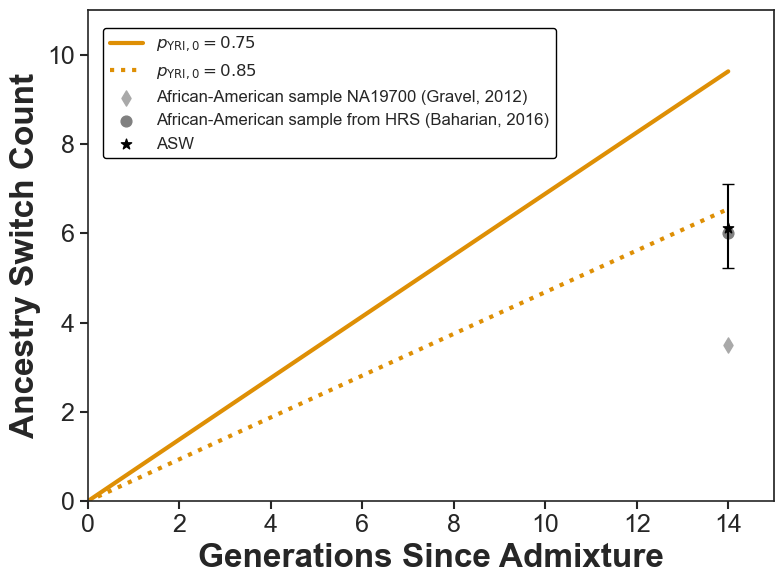

In [23]:
LABEL_FONTSIZE = 24
TICK_FONTSIZE  = 18
LEGEND_FONTSIZE = 12

sns.set_theme(style="white", palette="colorblind")
palette_sns = sns.color_palette("colorblind")

# Define consistent colors per Ne (map onto seaborn palette)
palette = {515: palette_sns[0], 728: palette_sns[1], 941: palette_sns[2]}
linestyles = {0.75: "solid", 0.85: "dotted"}  # solid for 0.75, dotted for 0.85

# Create figure + axis
fig, ax = plt.subplots(figsize=(8, 6))

for p_val, df in all_expected.groupby("p"):
    ax.plot(
        df["generation"], df["expected_switches"],
        label=fr"$p_{{\mathrm{{YRI}},0}} = {p_val}$",
        color=palette[N_e],            # since N_e is fixed
        linestyle=linestyles[p_val],
        linewidth=3,
    )

empirical_gen = 14  # x-position (generations since admixture)
asw_val = 6.11702127659574
asw_lower = 5.223
asw_upper = 7.106
gravel_val = 3.5
baharian_val = 6


# Gravel sample (point only)
ax.scatter(
    empirical_gen, gravel_val,
    color="darkgrey", marker="d", s=60,
    label="African-American sample NA19700 (Gravel, 2012)"
)

# Baharian sample (point only)
ax.scatter(
    empirical_gen, baharian_val,
    color="grey", marker="o", s=60,
    label="African-American sample from HRS (Baharian, 2016)"
)

ax.errorbar(
    empirical_gen, asw_val,
    yerr=[[asw_val - asw_lower], [asw_upper - asw_val]],
    fmt="none", ecolor="black", elinewidth=1.5, capsize=4
)

ax.scatter(
    empirical_gen, asw_val,
    color="black", marker="*", s=60,
    label="ASW"
)

# Axis labels
ax.set_xlabel("Generations Since Admixture", fontsize=LABEL_FONTSIZE, fontweight="bold")
ax.set_ylabel("Ancestry Switch Count", fontsize=LABEL_FONTSIZE, fontweight="bold")

# Tick + spine formatting
ax.tick_params(axis="both", which="major",
               direction="out", length=6, width=1.5,
               bottom=True, left=True, labelsize=TICK_FONTSIZE)
for spine in ["left", "bottom"]:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(1.2)

ax.margins(x=0, y=0)
ax.set_xlim(0, 15)   # go slightly past 14
ax.set_ylim(0, 11)   # show up to 10 on y-axis

# Legend
ax.legend(loc="upper left",
          bbox_to_anchor=(0.01, 0.98),
          fontsize=LEGEND_FONTSIZE,
          frameon=True, framealpha=1.0, edgecolor="black")

plt.tight_layout()
plt.savefig("figures/theory_empirical_switches.png", dpi=600)
plt.show()